#Подключаем библиотеки и загружаем данные

In [2]:
from sklearn import ensemble, model_selection, datasets, metrics, tree, linear_model, preprocessing 
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#Загрузить список стран и удалить лишние атрибуты 
countries = pd.read_csv("countries.csv")
countries.drop(['iso_alpha3','iso_numeric','official_name','name'], axis='columns',inplace=True)

#Загрузить список стран c датами
data_ans = pd.read_csv("/content/sample_submission_GcA3UZa.csv").iloc[:,:-1]
data_ans["confirmed"] = -1
data_ans = data_ans.merge(countries, how = 'left', left_on='country', right_on='iso_alpha2')
data_ans = data_ans[["date","ccse_name","confirmed"]]
data_ans["deaths"] = -1

#Загрузить данные по миру
data = pd.read_csv("time_series_covid19_confirmed_global.csv")
data = data.groupby("Country/Region").sum()
data_deaths = pd.read_csv("time_series_covid19_deaths_global.csv")
data_deaths = data_deaths.groupby("Country/Region").sum()

#Страна в строку. Каждый день это столбец
data_all = countries.merge(data, how = 'left', left_on='ccse_name', right_on='Country/Region')
data_all

,iso_alpha2,ccse_name,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20
0,AF,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237
1,AL,Albania,105,1.6,27400,36.0,-14000.0,2877797,0.63,0.0004,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259
2,DZ,Algeria,18,3.1,2381740,29.0,-10000.0,43851044,0.73,0.0056,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847
3,AD,Andorra,164,NaN,470,NaN,NaN,77265,0.88,0.0000,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390
4,AO,Angola,26,5.6,1246700,17.0,6413.0,32866272,0.67,0.0042,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,BF,Burkina Faso,76,5.2,273600,18.0,-25000.0,20903273,0.31,0.0027,12.2383,-1.5616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,3,15,15,20,33,40,64,75,99,114,146,152,180,207,222,246,261,282
165,UY,Uruguay,20,2.0,175020,36.0,-3000.0,3473730,0.96,0.0004,-32.5228,-55.7658,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,8,29,50,79,94,110,158,162,162,189,217,238,274,304,310,338,338
166,UZ,Uzbekistan,79,2.4,425400,28.0,-8863.0,33469203,0.50,0.0043,41.3775,64.5853,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,10,15,23,33,43,43,46,50,60,75,88,104,144,149,172,181
167,VE,Venezuela,32,2.3,882050,30.0,-653249.0,28435940,NaN,0.0036,6.4238,-66.5897,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,17,33,36,42,42,70,70,77,84,91,107,107,119,119,135,135,143


# Смотрим на первые страны

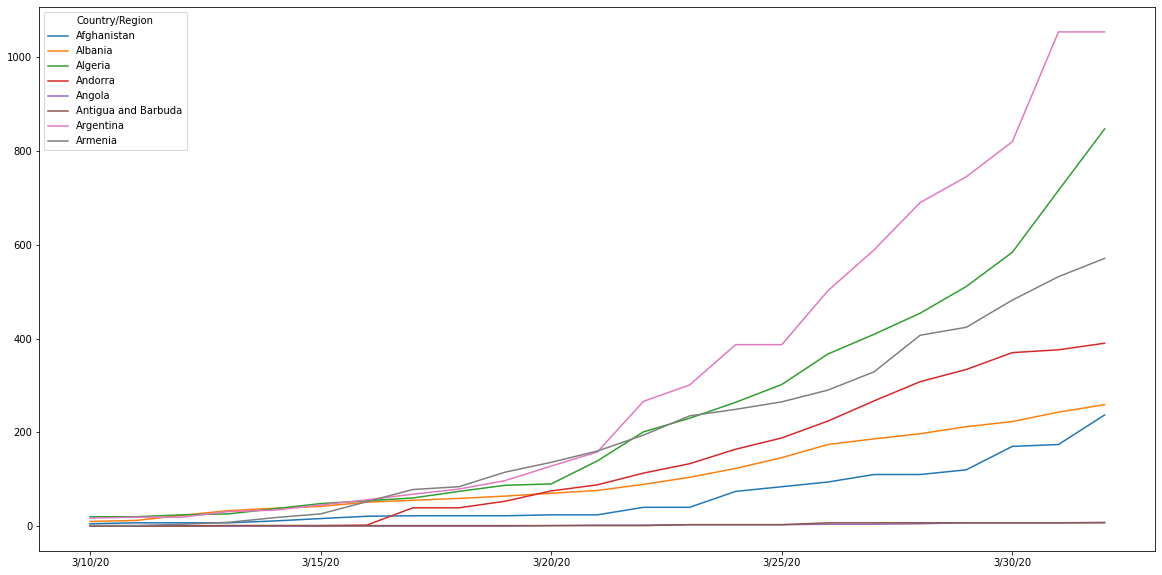

In [5]:
plt.rcParams['figure.figsize'] = [20, 10]
data.iloc[:8].T.iloc[50:].plot()

# Представляем данные в виде, где каждой дате соответствует свой столбец

In [0]:
#Каждый день на новой строке
data_deaths = data_deaths.iloc[:,4:].stack().reset_index()
data_deaths.columns = ["ccse_name","date","deaths"]
data2 = data.iloc[:,4:].stack().reset_index()
data2.columns = ["ccse_name","date","confirmed"]

#Соединим смерти и заражения
data2 = data2.merge(data_deaths, how = 'left', left_on=('ccse_name','date'), right_on=('ccse_name','date'))

#Объединим с будущим
data2 = pd.concat([data2, data_ans],ignore_index=True)

#Добавим информацию о стране(плотность, население и тд)
data2 = data2.merge(countries, how = 'right', left_on='ccse_name', right_on='ccse_name')

#Удалим дни без больных
data2 = data2[data2.confirmed != 0]

# Добавляем признак, количество дней от первого зараженного

In [7]:
# Считаем дни от первого больного
data2["date"] = pd.to_datetime(data2.date)
data2 = data2[(data2["date"]<pd.to_datetime("2020-05-1")) & ((data2["date"]>pd.to_datetime("2020-04-1")) | (data2.confirmed !=-1))]
data4 = data2[["ccse_name","date"]].groupby("ccse_name").min()
data4.columns = ["Date_min"]
data2 = data2.merge(data4, how = 'left', left_on='ccse_name', right_on='ccse_name')
data2["days"] = (data2.date - data2.Date_min).dt.days
data2["days_mart"] = (data2.date - pd.to_datetime("2020-03-1")).dt.days
data2.drop(['date','Date_min'], axis='columns',inplace=True)
data2 = data2.dropna(axis='index', how='any')
data2

,ccse_name,confirmed,deaths,iso_alpha2,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,days,days_mart
0,Afghanistan,1,0,AF,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,0,-6
1,Afghanistan,1,0,AF,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,1,-5
2,Afghanistan,1,0,AF,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2,-4
3,Afghanistan,1,0,AF,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,3,-3
4,Afghanistan,1,0,AF,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,4,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10127,Zimbabwe,-1,-1,ZW,38,3.6,386850,19.0,-116858.0,14862924,0.38,0.0019,37,56
10128,Zimbabwe,-1,-1,ZW,38,3.6,386850,19.0,-116858.0,14862924,0.38,0.0019,38,57
10129,Zimbabwe,-1,-1,ZW,38,3.6,386850,19.0,-116858.0,14862924,0.38,0.0019,39,58
10130,Zimbabwe,-1,-1,ZW,38,3.6,386850,19.0,-116858.0,14862924,0.38,0.0019,40,59


# Добавить данные за прошлый день

In [10]:
old_con = data2["confirmed"].iloc[:-1]
old_con2 = data2["deaths"].iloc[:-1]
data2 = data2.iloc[1:]
data2["pred_conf"] = old_con.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Отделяем данные на трейн и тест

In [11]:
#Выберите день начала приватных данных
days_x = 25

#Удаляем ненужные фичи
#data3 = data2.drop(['world_share','urban_pop_rate','population', 'migrants','median_age','land_area','fertility_rate','density'], axis='columns')
data3 = data2.drop(['world_share', 'migrants','median_age','land_area','fertility_rate','density'], axis='columns')
#data3 = data2.drop(['delta_deaths2','delta_deaths1','pred_deaths'], axis='columns')
data3.population = data3.population/10**6

#Представляем страны в one_hot
#one_hot = pd.get_dummies(data3['iso_alpha2'])
#data3 = data3.join(one_hot)

#Отделяем пару стран на тест
data_France = data3[(data3.ccse_name == 'France') & (data3.confirmed > 0)]
data_Russia = data3[(data3.ccse_name == 'Russia') & (data3.confirmed > 0)]

#Приватные данные
new_data = data3[data2.days_mart >= days_x]
old_data = data3[data2.days_mart < days_x]
old_data = old_data[(old_data.ccse_name != 'Russia')&(old_data.ccse_name != 'France')]

#Логорифмируем предсказания
#old_data["confirmed"] = log(old_data.confirmed) 

#Убираем ответ из данных
train_labels = old_data.confirmed
train_death = old_data.deaths
train_data = old_data.drop(['iso_alpha2','confirmed','ccse_name','deaths'], axis='columns')
train_data

,population,urban_pop_rate,days,days_mart,pred_conf,pred_deaths,delta_conf1,delta_deaths1
3,38.928346,0.25,3,-3,1,0,0,0
4,38.928346,0.25,4,-2,1,0,0,0
5,38.928346,0.25,5,-1,1,0,0,0
6,38.928346,0.25,6,0,1,0,0,0
7,38.928346,0.25,7,1,1,0,0,0
...,...,...,...,...,...,...,...,...
10091,14.862924,0.38,1,20,1,0,2,1
10092,14.862924,0.38,2,21,3,0,2,0
10093,14.862924,0.38,3,22,3,0,0,0
10094,14.862924,0.38,4,23,3,1,0,1


# Предсказываем и строим графики

In [0]:
def plot_pred(model_name, data, exp_pr = False):
  labels = data.confirmed
  data = data.drop(['iso_alpha2','confirmed','ccse_name','deaths'], axis='columns')
  if exp_pr:
    data = scaler.transform(data)
  predictions = model_name.predict(data)
  print(metrics.mean_squared_error(labels, predictions))
  #Строи графики
  if exp_pr:
    plt.plot(np.exp(predictions))
  else:
    plt.plot(predictions)
  plt.plot(labels.values)

# Обучаем Линейная регрессия

In [14]:
# Масштабируем данные?
scaler_data = True
train_data_scaler = train_data
if scaler_data:
  scaler = preprocessing.StandardScaler()
  scaler.fit(train_data)
  train_data_scaler = scaler.transform(train_data)

reg = linear_model.Ridge()
reg.fit(train_data_scaler, np.log(train_labels))

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

375912.8724406743


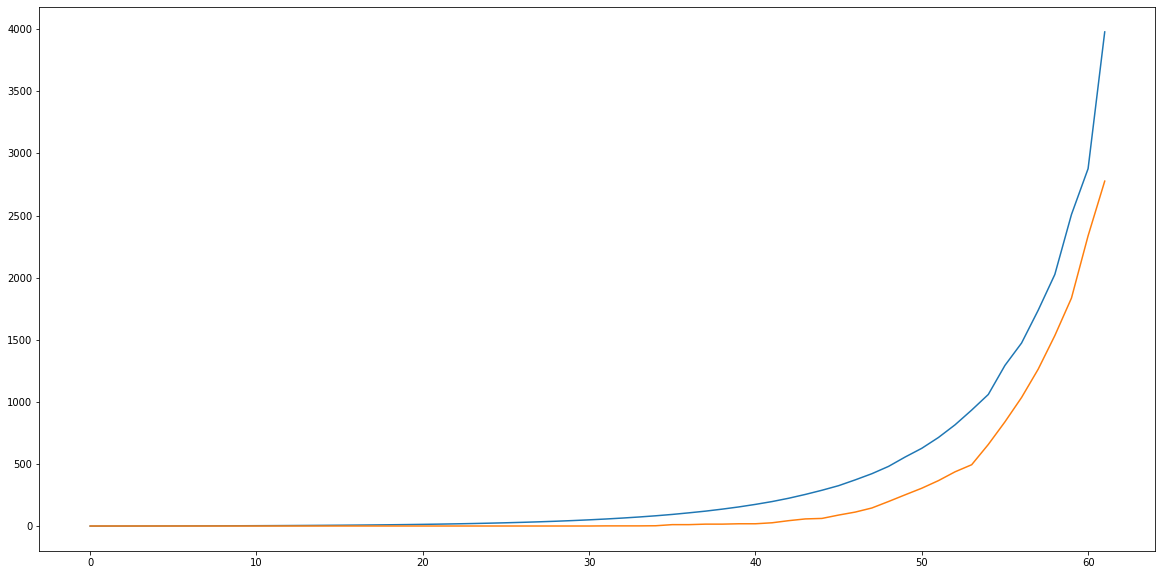

In [17]:
#Предсказываем для России
plot_pred(reg,data_Russia,True)


229575332.71102273


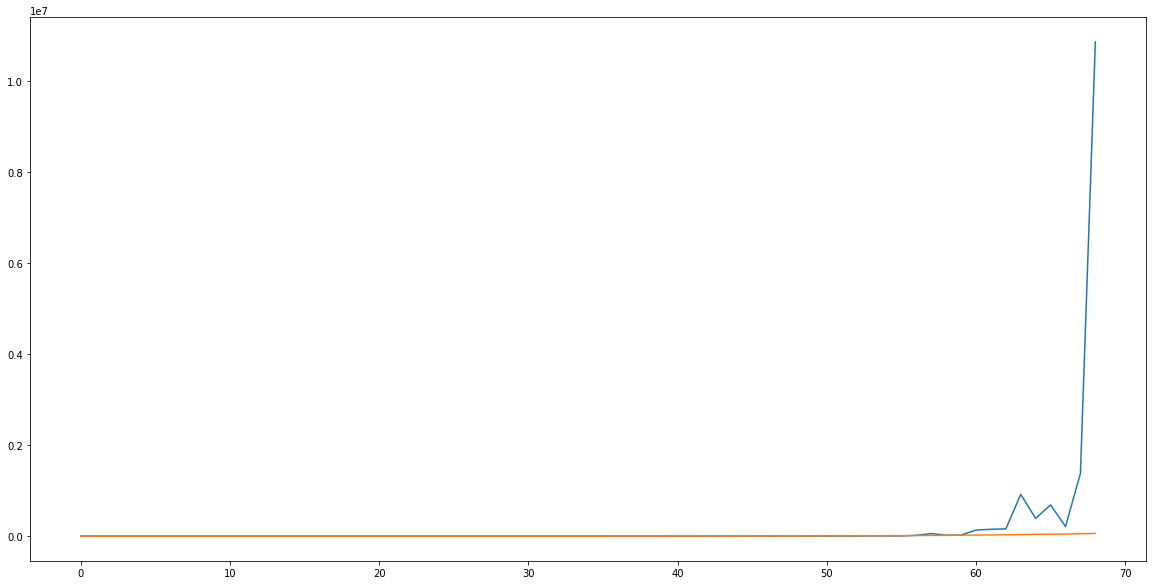

In [18]:
#Предсказываем для Франции
plot_pred(reg,data_France,True)

# Обучаем Adaboost Regressor

In [19]:
treeDepth = 10
mdl = tree.DecisionTreeRegressor(max_depth=treeDepth)
param_grid = {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.1, 0.01, 0.001]
                }
regrMdl = ensemble.AdaBoostRegressor(base_estimator=mdl)
Ada = model_selection.RandomizedSearchCV(estimator = regrMdl, param_distributions = param_grid,
                                      n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
Ada.fit(train_data, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                    criterion='mse',
                                                                                    max_depth=10,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                       

1099.8944810674716


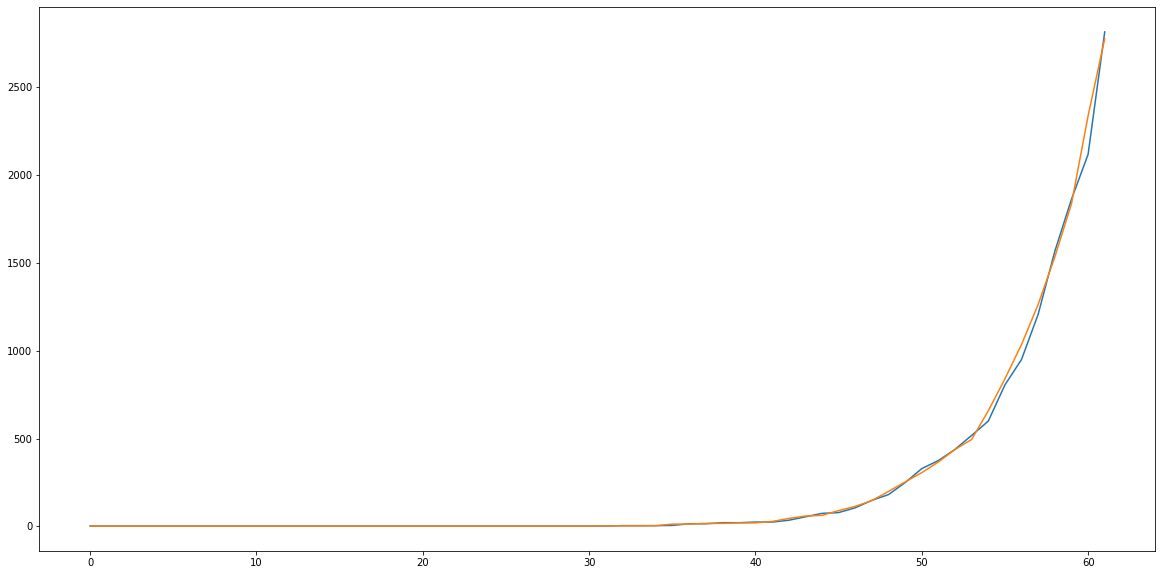

In [20]:
#Предсказываем для России
plot_pred(Ada,data_Russia)

780372.9445172095


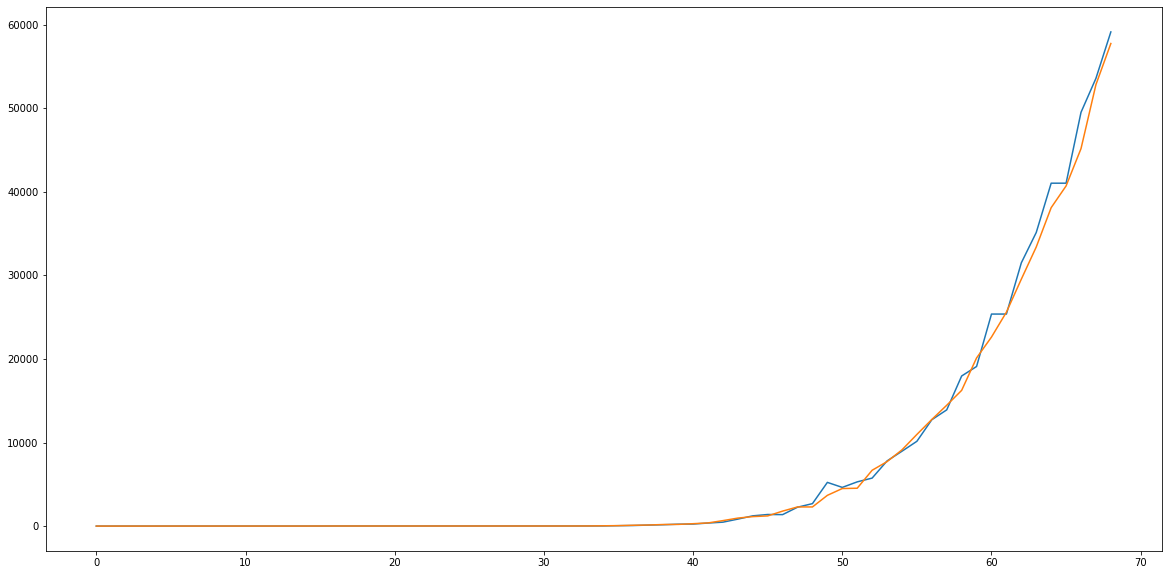

In [21]:
#Предсказываем для Франции
plot_pred(Ada,data_France)

# Обучаем случайный лес

In [22]:
#Обучаем случайный лес
clf = ensemble.RandomForestClassifier(n_estimators=200, max_depth=30)
clf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

780561.8387096775


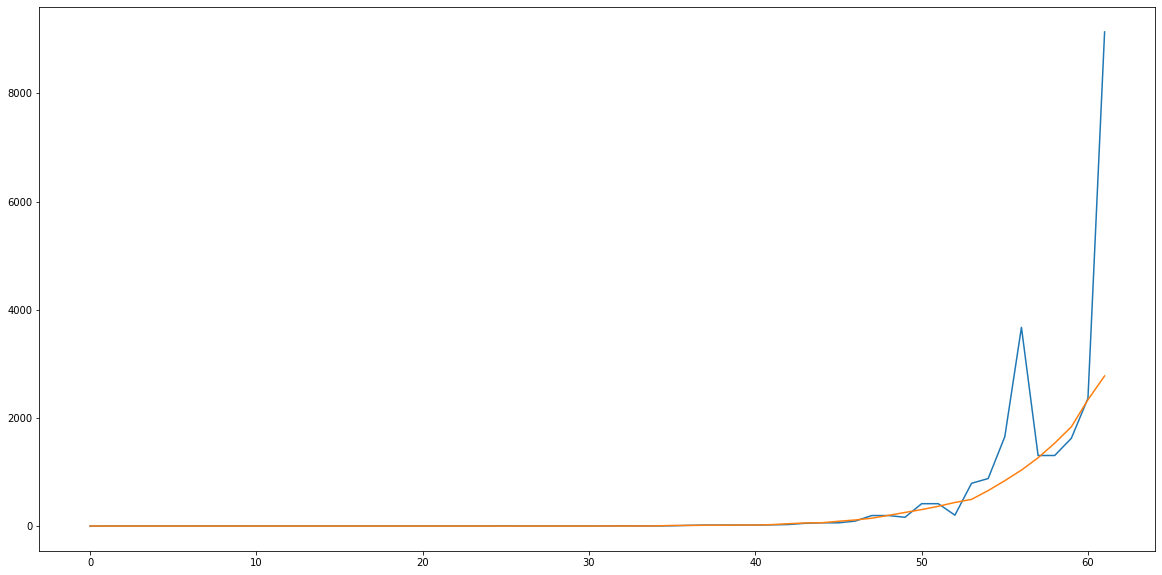

In [23]:
#Предсказываем для России
plot_pred(clf,data_Russia)

65518758.57971015


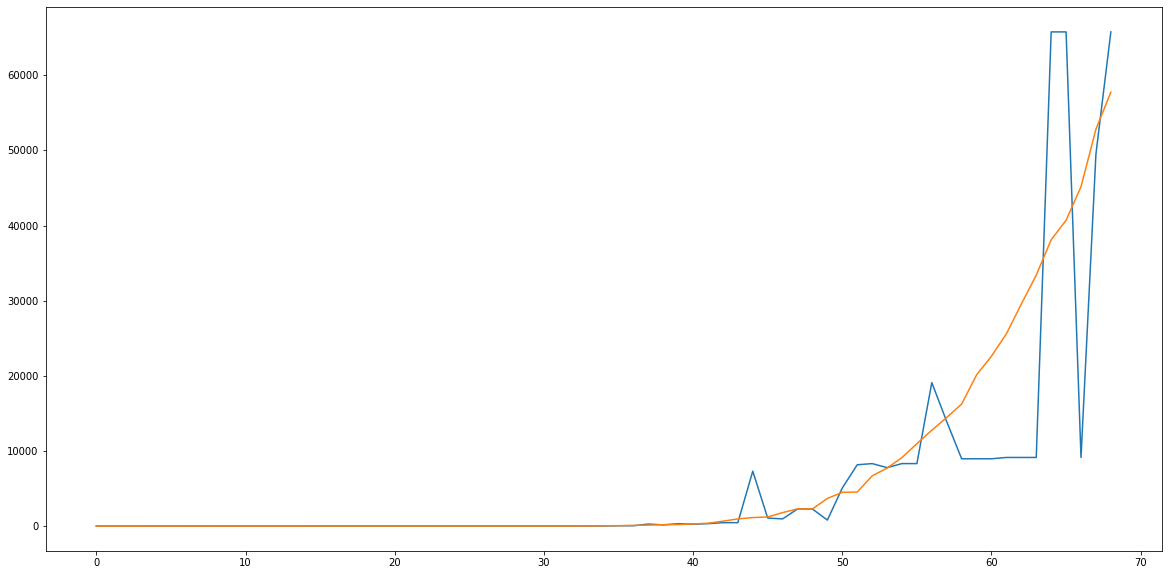

In [24]:
#Предсказываем для Франции
plot_pred(clf,data_France)

# Обучаем xgboost

In [0]:
modelXGB = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000).fit(train_data, train_labels)

1987.0289369764903


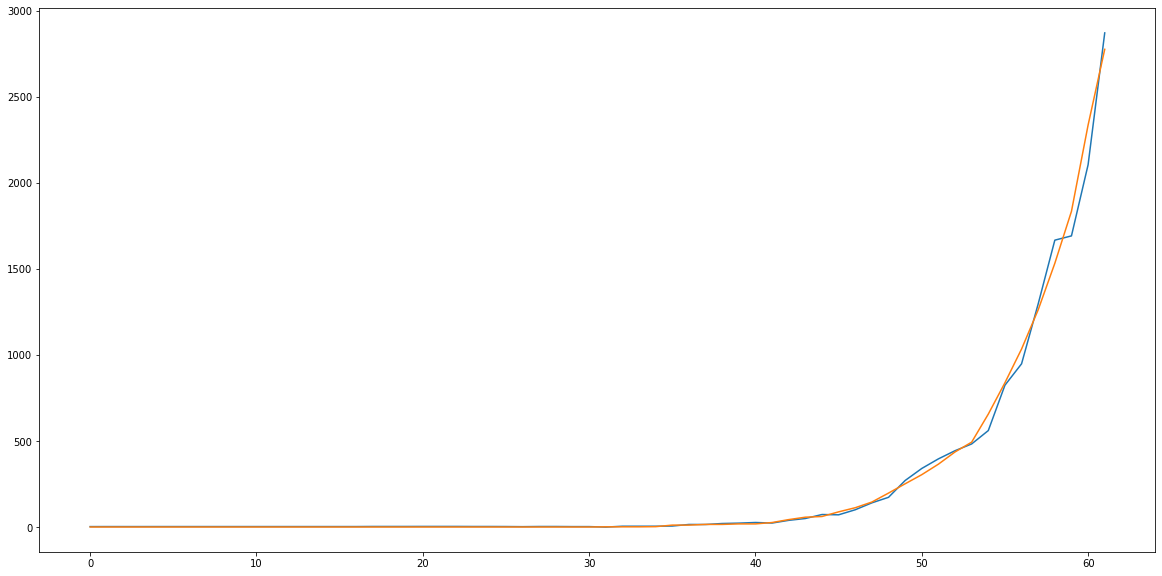

In [26]:
#Предсказываем для России
plot_pred(modelXGB,data_Russia)

1505233.4877654188


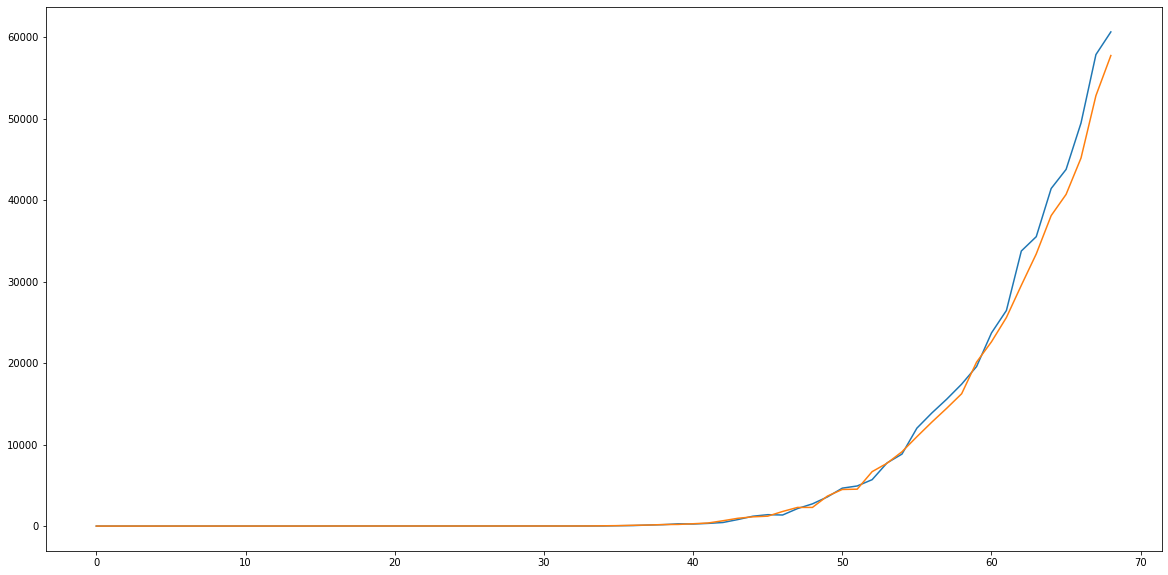

In [27]:
#Предсказываем для Франции
plot_pred(modelXGB,data_France)

#Предсказываем новые данные

In [0]:
# modelXGB , clf , Ada
model_name = Ada
new_data_list = new_data[new_data.days_mart == days_x]
labels = new_data_list.iso_alpha2
data = new_data_list.drop(['iso_alpha2','confirmed','ccse_name','deaths'], axis='columns')
predictions = []
for _ in range(25):
  prediction = model_name.predict(data)
  data["pred_conf"] = prediction
  data[["days_mart", "days"]] += 1
  predictions.append(prediction)
Mat_pred = pd.DataFrame(predictions,columns = labels)


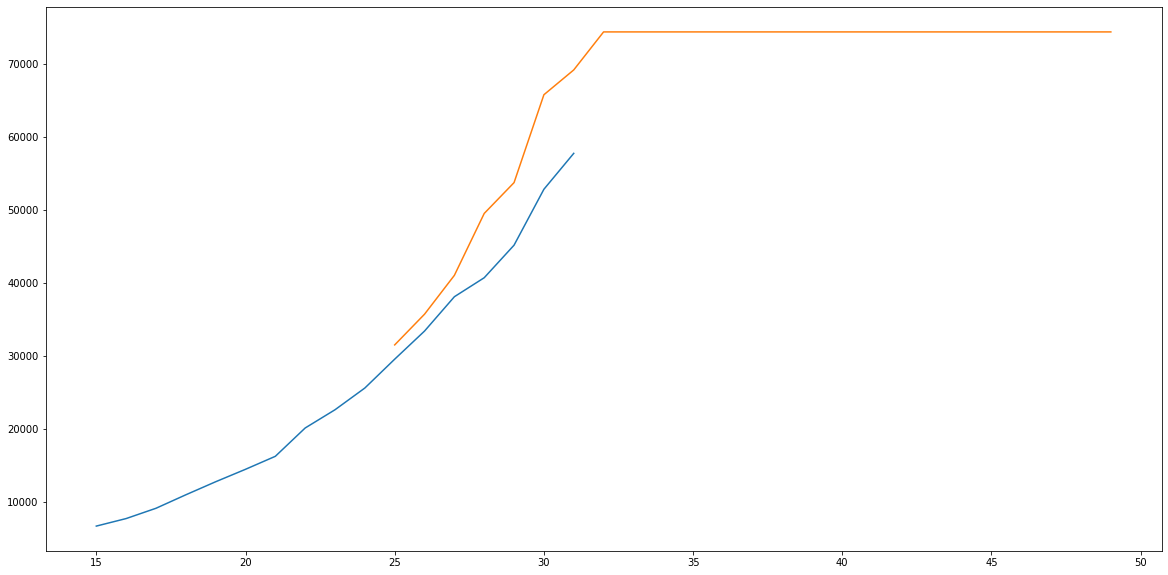

In [30]:
Country = 'FR'
yyy2 = Mat_pred[Country]
yyy = data2[(data2.iso_alpha2 == Country)&(data2.confirmed>0)&(data2.days_mart>=days_x - 10)]
plt.plot(yyy.days_mart,yyy.confirmed)
plt.plot(days_x + yyy2.index,yyy2)

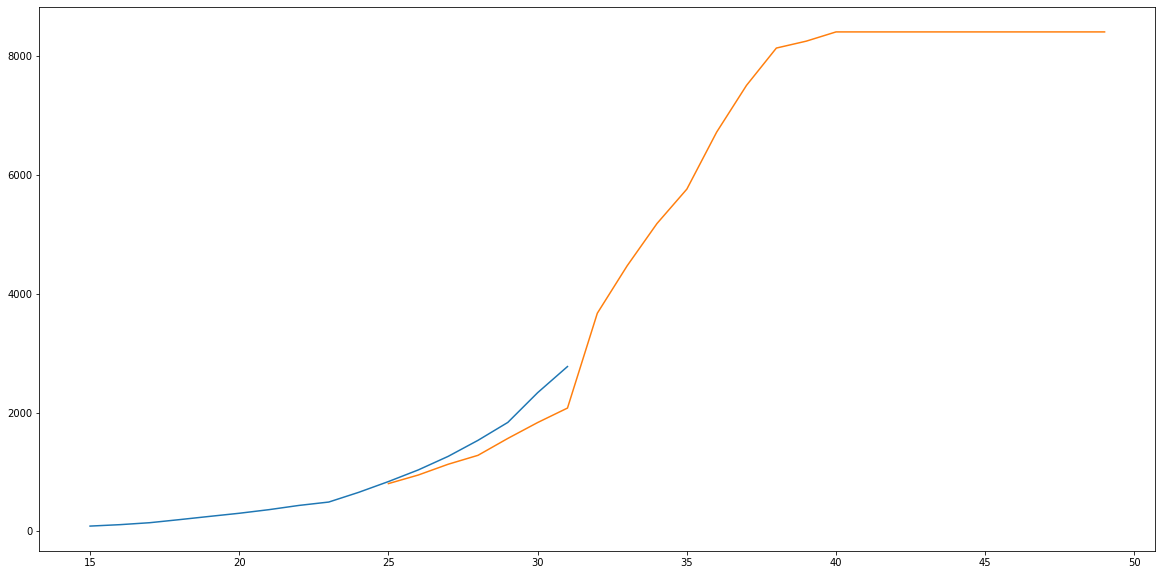

In [31]:
Country = 'RU'
yyy2 = Mat_pred[Country]
yyy = data2[(data2.iso_alpha2 == Country)&(data2.confirmed>0)&(data2.days_mart>=days_x - 10)]
plt.plot(yyy.days_mart,yyy.confirmed)
plt.plot(days_x + yyy2.index,yyy2)